# Mustererkennung/Machine Learning - Assignment 6



In [68]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import random
import math
from pprint import pprint
import seaborn as sns
from sklearn import metrics

###Load the spam dataset:

In [69]:
data = np.array(pd.read_csv('spambase.data', header=None))
feature_names=['word_freq_make',
'word_freq_address',
'word_freq_all',
'word_freq_3d',
'word_freq_our',
'word_freq_over',
'word_freq_remove',
'word_freq_internet',
'word_freq_order',
'word_freq_mail',
'word_freq_receive',
'word_freq_will',
'word_freq_people',
'word_freq_report',
'word_freq_addresses',
'word_freq_free',
'word_freq_business',
'word_freq_email',
'word_freq_you',
'word_freq_credit',
'word_freq_your',
'word_freq_font',
'word_freq_000',
'word_freq_money',
'word_freq_hp',
'word_freq_hpl',
'word_freq_george',
'word_freq_650',
'word_freq_lab',
'word_freq_labs',
'word_freq_telnet',
'word_freq_857',
'word_freq_data',
'word_freq_415',
'word_freq_85',
'word_freq_technology',
'word_freq_1999',
'word_freq_parts',
'word_freq_pm',
'word_freq_direct',
'word_freq_cs',
'word_freq_meeting',
'word_freq_original',
'word_freq_project',
'word_freq_re',
'word_freq_edu',
'word_freq_table',
'word_freq_conference',
'char_freq_;',
'char_freq_(',
'char_freq_[',
'char_freq_!',
'char_freq_$',
'char_freq_#',
'capital_run_length_average',
'capital_run_length_longest',
'capital_run_length_total']

In [70]:
X = data[:,:-1] # features
#X_train = np.array([[0,1,1],[1,0,0],[0,1,1],[1,1,1],[0,1,0],[0,0,0],[1,1,0],[0,1,0],[0,0,0],[1,1,0]]) # features
y = data[:,-1] # Last column is label
#y_train = np.array([1,0,1,1,0,1,0,0,1,1]) # Last column is label
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, stratify=y)
total_train_samples=y_train.size #total samples

In [71]:
#confusion matrix plotting
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [72]:
# Create a leaf node value based on majority vote
def to_terminal(outcomes):
    return np.round(np.mean(outcomes))

In [73]:
#This gives best split node for decision tree uisng gini impurity
def find_split(X_train, y_train):
    class_values = np.unique(y_train)
    X,Y=X_train,y_train
    #parameter initialization
    min_gini=999 
    z=999
    col=999
    gini_total=0
    best_tree_childs=()
    #for each column
    for j in range(X_train.shape[-1]):
        #indices=np.argsort(X_train[:, j])
        #X,Y=X_train[indices],y_train[indices]
        #if we take unique value for j-th column into account then it reduces the time computation instead of individual value
        unique_values_to_split=np.unique(X[:,j])
        #for each unique value of j-th column 
        for i in unique_values_to_split:
            curr_z=i
            #splitted data based on current value of j-th column
            y_left,y_right=Y[X[:, j] < curr_z],Y[X[:, j] >= curr_z]
            c1=to_terminal(y_left)
            #print('c1',c1)
            c2=to_terminal(y_right)
            childs=(y_left,y_right)  
            #weighted average gini impurity value for both groups left and right child
            gini=gini_index(childs, class_values)
            #print(j,i,gini)
            #best gini value which is minimum among all values
            if min_gini>gini:
                min_gini=gini
                z=curr_z
                c1_temp=c1
                c2_temp=c2
                col=j
                best_tree_childs=childs
    #parent node gini impuirty calculation
    for class_val in class_values:
        p = [y for y in y_train].count(class_val) / y_train.size
        gini_total += p * p
    gini_parent=1-gini_total
    #gini gain if we split parent into left child and right child which is basically will be used to calculate feature importance
    gini_gain=(gini_parent-min_gini)*y_train.size / total_train_samples
    #print('X'+str(j_temp)+' cutoff: '+str(z))
    return z,col,gini_gain,best_tree_childs

In [74]:
# Calculate the Gini index for a split dataset
def gini_index(childs, classes):
    # count all samples at split point
    n_instances = float(sum([child_node.size for child_node in childs]))
    # sum weighted Gini index for each childs
    gini=0
    for child_node in childs:
        size = float(child_node.size)
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row for row in child_node].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)   
    return gini

In [75]:
class DecisionTreeClassifier():
    #initialiazation with math depth(max_depth) and minimum no of asmples for leaf(t)
    def __init__(self, max_depth=5,t=1):
        self.max_depth = max_depth
        self.t=t
    #fit method with parameters dataset, parent node information and depth of the tree
    def fit(self, x, y, par_node={}, depth=0):
            t=self.t
            cutoff,col, gini_gain,best_tree_childs = find_split(x, y)    # find best split given a gini impurity 
            #best split information assignment for tree node
            par_node = {'col': 'X'+str(col), 'index_col':col,'cutoff':cutoff,'gini_gain':gini_gain }
            y_left,y_right=best_tree_childs
            #print('y_left:',y_left.size,' y_right ',y_right.size)
            #if any of the child samples are zero then there is no need of further split 
            if y_left.size==0 or y_right.size==0:
                par_node['left'] = par_node['right'] = to_terminal(list(y_left) + list(y_right))
                return par_node
            # trif ee depth is greater than equals to max depth then we can stop here
            if depth >= self.max_depth:
                par_node['left'], par_node['right'] = to_terminal(y_left), to_terminal(y_right)
                return par_node
            #stop if leaf nodes have less samples than the specified value otherwise split further
            if y_left.size<=t:
                par_node['left']=np.round(np.mean(y_left))
            else:
                par_node['left'] = self.fit(x[x[:, col] < cutoff], y_left, {}, depth+1)
            
            if y_right.size<=t:
                par_node['right']=np.round(np.mean(y_right))
            else:
                par_node['right'] = self.fit(x[x[:, col] >= cutoff], y_right, {}, depth+1) 
            self.trees = par_node
            return par_node

In [76]:
#prediction using trained parameters of tree
def predict( m,x):
    tree = m
    results = np.array([0]*len(x))
    for i, c in enumerate(x):
        results[i] = get_prediction(m,c)
    return results
    
def get_prediction(m, row):
    cur_layer = m
    while cur_layer['cutoff'] is not None:
        if row[cur_layer['index_col']] <= cur_layer['cutoff']:
            if isinstance(cur_layer['left'], dict):
                cur_layer = cur_layer['left']
            else:
                return cur_layer['left']
        else:
            if isinstance(cur_layer['right'], dict):
                cur_layer = cur_layer['right']
            else:
                return cur_layer['right']
        #print('cutoff',cur_layer['cutoff'])



In [77]:
def plot_model_report(y_test,y_pred):
    # Generate a classification report
    cm_plot_labels = ['Not Spam', 'Spam']
    # For this to work we need y_pred as binary labels not as probabilities
    #y_pred_binary = np.where(predictions > 0.5, 1, 0)

    report = classification_report(y_test, y_pred, target_names=cm_plot_labels)

    print(report)

    # argmax returns the index of the max value in a row
    cm = confusion_matrix(y_test, y_pred)

    plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# (a) Assume that classifying a genuine E-Mail as spam is ten times worse than classifying spam as genuine. How would you change the design of your decision tree?
Answer: I guess differences in accuracies between class non spam and class spam come from the class_weight parameter you have used. Class spam will benefit from this overweighting towards class non spam. You could try to play on this parameter to re-balance your results in class non spam and class spam. 

other solution could be, we can increase or decrese the minimum number of samples at leaf node by keeping max depth constant or we can increase or decrese max depth by keeping minimum number of samples as constant to overcome this problem.

# (b) Use your tree to analyze feature importance. Plot the difference between the top 5 features (check spambase.names to check what features those belong to).
Answer:
As part of feature importance calculation, We have calculated the gini gain at every best split as follows :

N_t / N * (impurity - N_t_R / N_t * right_impurity
                      - N_t_L / N_t * left_impurity)

where N is the total number of samples, N_t is the number of samples at the current node, N_t_L is the number of samples in the left child, and N_t_R is the number of samples in the right child.

after training the model we have calculated the feature importance as sum of all gini gain where feature X was the cause of split.

In [78]:
#feature importance calculation
class f_importance():
    def __init__(self, features=1):
        self.res = {k:0 for k in range(features)}
    #
    def f_importance_calculation(self, root):
            
            if root:
                self.res[root['index_col']]+=root['gini_gain']
                if isinstance(root['left'], dict):
                    self.f_importance_calculation(root['left'])
                if isinstance(root['right'], dict):
                    self.f_importance_calculation( root['right'])
            return self.res

In [79]:
def call_decision_tree():
    #decision tree with max depth  as 10 amd minimum samples at leaf node as 1
    clf = DecisionTreeClassifier(max_depth=10, t=1)
    tree = clf.fit(X_train, y_train)
    pprint(tree) #to print tree
    
    #prediction on test set 
    y_pred=predict(tree,X_test)
   
    #feature imprtance calculation
    feature_importance=f_importance(features=X_train.shape[-1]).f_importance_calculation(tree)
    feat_imp_list=[]
    for k, v in zip(feature_names,feature_importance.items()):
        print(k,v)
        feat_imp_list.append((k,v[1]))
    Sorted_feature=[[key,value] for key, value in sorted(feat_imp_list,reverse=True, key=lambda item: item[1])]
    feat=[]
    score=[]
    for row in Sorted_feature:
        feat.append(row[0])
        score.append(row[1])


    #sns.set_style('darkgrid')

    sns.barplot(score[0:5],feat[0:5])
    plt.xlabel('Feature importance value')
    plt.ylabel('Features')
    plt.show()
    
    plot_model_report(y_test,y_pred) #model report plotting

/home/suresh/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/suresh/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'col': 'X51',
 'cutoff': 0.079,
 'gini_gain': 0.1573079330035172,
 'index_col': 51,
 'left': {'col': 'X6',
          'cutoff': 0.05,
          'gini_gain': 0.036940589137910096,
          'index_col': 6,
          'left': {'col': 'X23',
                   'cutoff': 0.02,
                   'gini_gain': 0.013600533060163808,
                   'index_col': 23,
                   'left': {'col': 'X15',
                            'cutoff': 0.2,
                            'gini_gain': 0.0043473035328583055,
                            'index_col': 15,
                            'left': {'col': 'X52',
                                     'cutoff': 0.182,
                                     'gini_gain': 0.004177741889223485,
                                     'index_col': 52,
                                     'left': {'col': 'X3',
                                              'cutoff': 0.44,
                                              'gini_gain': 0.0010432403678429902,
         

/home/suresh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


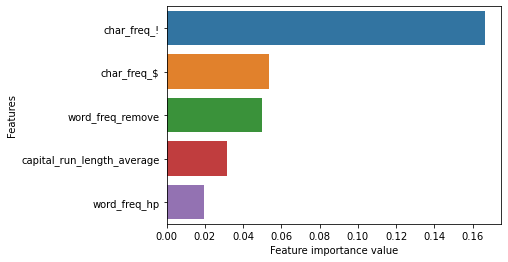

              precision    recall  f1-score   support

    Not Spam       0.93      0.94      0.93       697
        Spam       0.90      0.89      0.90       454

    accuracy                           0.92      1151
   macro avg       0.92      0.92      0.92      1151
weighted avg       0.92      0.92      0.92      1151

Confusion matrix, without normalization
[[653  44]
 [ 48 406]]


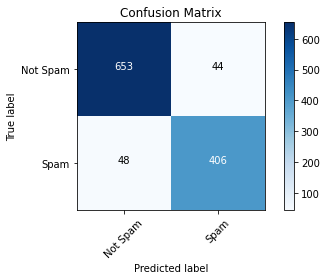

In [80]:
call_decision_tree()

In [81]:
#bootstrap samples
def draw_bootstrap(X_train, y_train):
    bootstrap_indices = list(np.random.choice(range(len(X_train)), len(X_train), replace = True))
    oob_indices = [i for i in range(len(X_train)) if i not in bootstrap_indices]
    X_bootstrap = X_train[bootstrap_indices,:]
    y_bootstrap = y_train[bootstrap_indices]
    X_oob = X_train[oob_indices,:]
    y_oob = y_train[oob_indices]
    return X_bootstrap, y_bootstrap, X_oob, y_oob

In [82]:
# prediction with a list of  trees
def rf_predict(trees,feature_list, row):
	predictions = [get_prediction(tree, row[feature]) for tree,feature in zip(trees,feature_list)]
	return max(set(predictions), key=predictions.count)
 
# Random Forest Algorithm
def random_forest(X_train, y_train, max_depth, min_size, n_trees, n_features=None):
    trees = list()
    feature_list=list()
    random_n_features=None
    for i in range(n_trees):
        X_bootstrap, y_bootstrap, X_oob, y_oob=draw_bootstrap(X_train, y_train)
        if n_features is not None:
            random_n_features=random.sample(range(1, X_train.shape[-1]), n_features)
        else:
            random_n_features=random.sample(range(1, X_train.shape[-1]), int(np.round(math.sqrt(X_train.shape[-1]))))
        clf = DecisionTreeClassifier(max_depth, t=min_size)
        tree = clf.fit(X_bootstrap[:,random_n_features], y_bootstrap)
        trees.append(tree)
        feature_list.append(random_n_features)
    return trees,feature_list


In [83]:
def main():
    
    call_decision_tree()# decision tree function called, for parameters you can visit this function, defaut parameters are maxdeptth with 10 and minimum samples as 1.
    
    #random forest
    AUC_list=[]
    F1_score_list=[]
    for n_t in range(1,200,10):
        print("Random forest model training in progress")
        trees,feature_list=random_forest(X_train, y_train, max_depth=10, min_size=1, n_trees=n_t)
        y_pred = [rf_predict(trees,feature_list, row) for row in X_test]
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
        AUC_list.append(metrics.auc(fpr, tpr))
        F1_score_list.append(metrics.f1_score(y_test, y_pred))
    #save the results in a file
    f = open("RF-result.txt", "w")
    for auc,f1,nt in zip(AUC_list,F1_score_list,range(1,200,10)):
        f.write(str(auc)+','+str(f1)+','+str(nt)+'\n')
    f.close()
    

/home/suresh/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/suresh/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'col': 'X51',
 'cutoff': 0.079,
 'gini_gain': 0.1573079330035172,
 'index_col': 51,
 'left': {'col': 'X6',
          'cutoff': 0.05,
          'gini_gain': 0.036940589137910096,
          'index_col': 6,
          'left': {'col': 'X23',
                   'cutoff': 0.02,
                   'gini_gain': 0.013600533060163808,
                   'index_col': 23,
                   'left': {'col': 'X15',
                            'cutoff': 0.2,
                            'gini_gain': 0.0043473035328583055,
                            'index_col': 15,
                            'left': {'col': 'X52',
                                     'cutoff': 0.182,
                                     'gini_gain': 0.004177741889223485,
                                     'index_col': 52,
                                     'left': {'col': 'X3',
                                              'cutoff': 0.44,
                                              'gini_gain': 0.0010432403678429902,
         

/home/suresh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


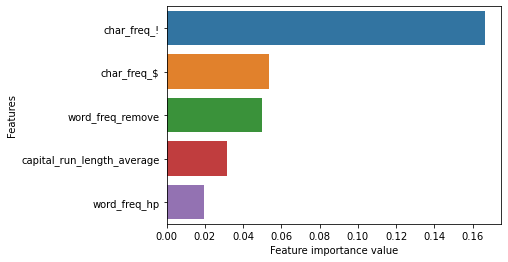

              precision    recall  f1-score   support

    Not Spam       0.93      0.94      0.93       697
        Spam       0.90      0.89      0.90       454

    accuracy                           0.92      1151
   macro avg       0.92      0.92      0.92      1151
weighted avg       0.92      0.92      0.92      1151

Confusion matrix, without normalization
[[653  44]
 [ 48 406]]
Random forest model training in progress


/home/suresh/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/suresh/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Random forest model training in progress
Random forest model training in progress
Random forest model training in progress
Random forest model training in progress
Random forest model training in progress
Random forest model training in progress
Random forest model training in progress
Random forest model training in progress
Random forest model training in progress
Random forest model training in progress
Random forest model training in progress
Random forest model training in progress
Random forest model training in progress
Random forest model training in progress
Random forest model training in progress
Random forest model training in progress
Random forest model training in progress
Random forest model training in progress
Random forest model training in progress


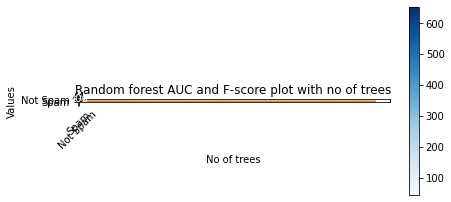

In [84]:
#main()

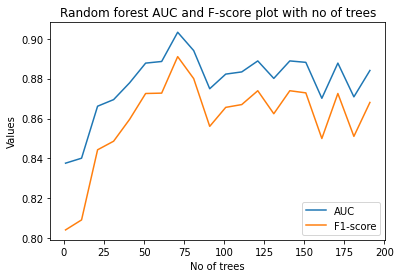

In [90]:
data = pd.read_csv('RF-result.txt', header=None)
data.head()
#AUC plot
plt.plot(data[2], data[0], label = "AUC")

# plotting the line 2 points 
plt.plot(data[2],data[1], label = "F1-score")
plt.title('Random forest AUC and F-score plot with no of trees')
plt.xlabel('No of trees')
plt.ylabel('Values')
plt.legend(loc=4)
plt.show()

# (a) Print a confusion matrix (you can use package implementations here).


Best Random forest model with 71 trees 


/home/suresh/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/suresh/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


              precision    recall  f1-score   support

    Not Spam       0.86      0.99      0.92       697
        Spam       0.98      0.76      0.85       454

    accuracy                           0.90      1151
   macro avg       0.92      0.87      0.89      1151
weighted avg       0.91      0.90      0.90      1151

Confusion matrix, without normalization
[[690   7]
 [110 344]]


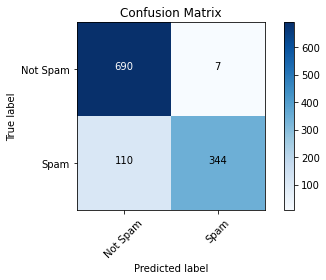

In [89]:
print("Best Random forest model with 71 trees ")
trees,feature_list=random_forest(X_train, y_train, max_depth=10, min_size=1, n_trees=71)
y_pred = [rf_predict(trees,feature_list, row) for row in X_test]
plot_model_report(y_test,y_pred) #model report plotting

# (b) What is a good number of trees in the forest?
Answer: To get good number of trees we tried gridsearch with varying number of trees and plotted their respective accuracies(F1-score and AUC),which can be seen in above plotted figure we found 131 number of trees is best in the forest.